In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [3]:
from DomainPrediction.utils import helper
from DomainPrediction.utils.constants import *
from DomainPrediction.protein.base import BaseProtein
from DomainPrediction.al import top_model as topmodel

In [5]:
sys.path.append('../../esm')
from DomainPrediction.esm.esmc import ESMCLM

### Setup Dataset

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/round_3_exp'

In [7]:
df_t_domain = pd.read_csv(os.path.join(data_path, 'dataset_2_tdomain.csv'))

In [8]:
df_t_domain.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,1.730126,0,45,0.548194
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.073117,2,46,-2.615701
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059


In [9]:
df_t_domain['split_id_1'] = 2
df_t_domain['split_id_2'] = 2
df_t_domain.loc[df_t_domain['name'].str.contains('WT_EP|DESIGN'), 'split_id_1'] = 0

In [10]:
df_t_domain.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log,split_id_1,split_id_2
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000,2,2
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670,2,2
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,1.730126,0,45,0.548194,2,2
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.073117,2,46,-2.615701,2,2
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059,2,2


In [11]:
for split in df_t_domain.columns[df_t_domain.columns.str.contains('split')]:
    print(f"{split}\t Train: {df_t_domain[split].isin([2]).sum()} Test: {df_t_domain[split].isin([0, 1]).sum()}")

split_id	 Train: 55 Test: 30
split_id_1	 Train: 51 Test: 34
split_id_2	 Train: 85 Test: 0


In [12]:
def get_spearmanr_bootstrap(a, b, n=1000):
    assert type(a) == type(b) == np.ndarray
    assert len(a) == len(b)
    corr = []
    p_value = []
    np.random.seed(0)
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        res = stats.spearmanr(a[indices], b[indices])
        
        if not np.isnan(res.statistic):
            corr.append(res.statistic)
            p_value.append(res.pvalue)

    ci_lower, ci_upper = np.percentile(corr, [5, 95]) 
    # stats.t.interval(confidence=0.95, df=len(corr)-1, loc=np.mean(corr), scale=np.std(corr))
    mean_corr = np.mean(corr)

    return round(mean_corr, 2), round(ci_lower, 2), round(ci_upper, 2), corr, p_value

### Setup gen dataset

In [13]:
df_gen = pd.read_csv(os.path.join(data_path, 'gen_pred.csv'))

In [14]:
df_gen.head()

,name,sequence,masked_sequence,n_mut,esmc_wt_marginal,esmc_masked_marginal,esmc_pll,esmc_full_wt_marginal,esmc_full_masked_marginal,mut_bin,pred_confit_1,pred_confit_2,pred_confit_3
0,gxps_ATC_esm3_str_gen_0,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSAADYPKEPYVAPEGEAEQLLAQIWMELLGVERVGRHDNFFALG...,49,-44.019165,-16.101318,-152.53116,-58.318970,-41.270752,40-50,-8.140015,-13.653564,-10.770996
1,gxps_ATC_esm3_str_gen_1,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSDTDYPRTPYIAPEGAVEETLAAIWQDLLQVERVGRHDSFFALG...,47,-41.208496,-12.600098,-149.14124,-52.558716,-31.674561,40-50,-1.620117,-8.660645,-2.838379
2,gxps_ATC_esm3_str_gen_2,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,EPQASDYPAVPYEAPEGEQEQLLAGIWQELLGVERVGRHDNFFALG...,46,-46.686646,-22.641846,-157.42130,-57.561768,-43.364258,40-50,-10.613037,-12.717773,-12.023682
3,gxps_ATC_esm3_str_gen_3,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APAEDSFDRAPYVAPEGEVEQTLAGIWQELLQVERVGRHDSFFELG...,49,-31.578125,-2.216797,-155.64465,-40.660645,-28.473633,40-50,-6.089111,-11.967773,-10.611816
4,gxps_ATC_esm3_str_gen_4,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSEDDYPKPPYVAPEGEVEQLLAKIWQELLGVEKVGRHDSFFALG...,43,-44.613281,-16.470703,-156.66013,-50.236816,-36.729492,40-50,-6.050781,-11.535156,-5.494141


In [15]:
gxps_protein = BaseProtein(file='/nethome/kgeorge/workspace/DomainPrediction/Data/gxps/gxps_ATC_AF.pdb')
gxps_T_domain = ''.join([gxps_protein.sequence[i] for i in range(len(gxps_protein.sequence)) if i not in A_gxps_atc+C_gxps_atc])
gxps_base_seq = gxps_protein.sequence

assert len(gxps_T_domain) == 115

### generate Embeddings

In [16]:
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [17]:
embeddings_t_domain = esmc.get_embeddings_flatten(df_t_domain['seq'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:04<00:00, 19.13it/s]


In [18]:
embeddings_gen = esmc.get_embeddings_flatten(df_gen['masked_sequence'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8893/8893 [05:53<00:00, 25.12it/s]


### Run 1

In [21]:
train_mask, test_mask = df_t_domain['split_id'].isin([2]), df_t_domain['split_id'].isin([0, 1])
X_train = embeddings_t_domain[train_mask]
X_test = embeddings_t_domain[test_mask]

y_train = df_t_domain.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df_t_domain.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [22]:
print(f'train {train_mask.sum()} test {test_mask.sum()}')

train 55 test 30


In [23]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

train: mse = 0.18473133444786072, spearman correlation = 0.9767195792119246
val: mse = 7.83505916595459, spearman correlation = 0.7264434353551403


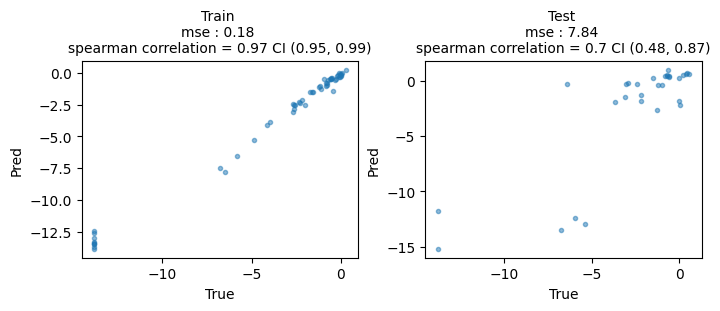

In [25]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [26]:
### Predcting for gen
y_pred = surrogate.predict(embeddings_gen)

In [27]:
y_pred.shape

(8893,)

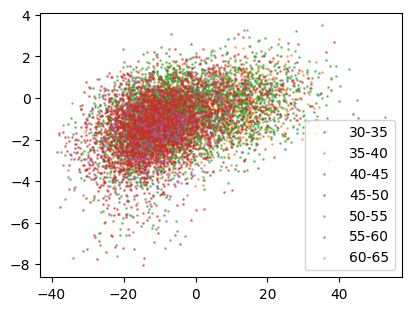

In [28]:
bins = list(range(30, 70, 5))  # Bins from 30 to 100 in steps of 10
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
mut_bin = pd.cut(df_gen['n_mut'], bins=bins, labels=bin_labels, include_lowest=True)
unique_bins = mut_bin.cat.categories

fig, ax = plt.subplots(1,1, figsize=(4,3), layout='constrained')
for _bin in unique_bins:
    _mask = mut_bin == _bin
    im = ax.scatter(df_gen['esmc_masked_marginal'][_mask], y_pred[_mask], alpha=0.5, s=1, label=_bin)
ax.legend()

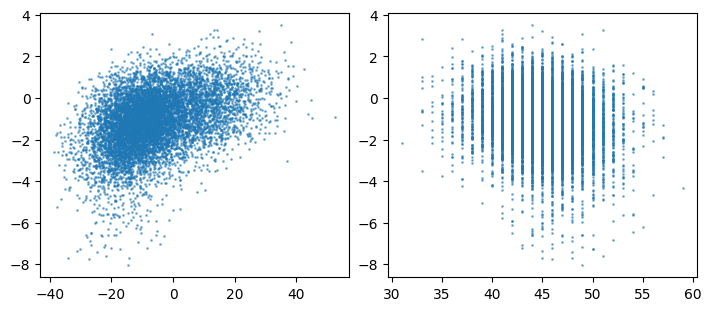

In [29]:
fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].scatter(df_gen['esmc_masked_marginal'], y_pred, alpha=0.5, s=1)
ax[1].scatter(df_gen['n_mut'], y_pred, alpha=0.5, s=1)

In [30]:
df_gen['pred_concat_1'] = y_pred

In [31]:
df_gen.head()

,name,sequence,masked_sequence,n_mut,esmc_wt_marginal,esmc_masked_marginal,esmc_pll,esmc_full_wt_marginal,esmc_full_masked_marginal,mut_bin,pred_confit_1,pred_confit_2,pred_confit_3,pred_concat_1
0,gxps_ATC_esm3_str_gen_0,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSAADYPKEPYVAPEGEAEQLLAQIWMELLGVERVGRHDNFFALG...,49,-44.019165,-16.101318,-152.53116,-58.318970,-41.270752,40-50,-8.140015,-13.653564,-10.770996,-2.623462
1,gxps_ATC_esm3_str_gen_1,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSDTDYPRTPYIAPEGAVEETLAAIWQDLLQVERVGRHDSFFALG...,47,-41.208496,-12.600098,-149.14124,-52.558716,-31.674561,40-50,-1.620117,-8.660645,-2.838379,-1.587067
2,gxps_ATC_esm3_str_gen_2,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,EPQASDYPAVPYEAPEGEQEQLLAGIWQELLGVERVGRHDNFFALG...,46,-46.686646,-22.641846,-157.42130,-57.561768,-43.364258,40-50,-10.613037,-12.717773,-12.023682,-3.302396
3,gxps_ATC_esm3_str_gen_3,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APAEDSFDRAPYVAPEGEVEQTLAGIWQELLQVERVGRHDSFFELG...,49,-31.578125,-2.216797,-155.64465,-40.660645,-28.473633,40-50,-6.089111,-11.967773,-10.611816,-2.219298
4,gxps_ATC_esm3_str_gen_4,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSEDDYPKPPYVAPEGEVEQLLAKIWQELLGVEKVGRHDSFFALG...,43,-44.613281,-16.470703,-156.66013,-50.236816,-36.729492,40-50,-6.050781,-11.535156,-5.494141,-3.334414


In [32]:
df_gen.to_csv(os.path.join(data_path, 'gen_pred.csv'), index=False)

### Run 2

In [33]:
train_mask, test_mask = df_t_domain['split_id_1'].isin([2]), df_t_domain['split_id_1'].isin([0, 1])
X_train = embeddings_t_domain[train_mask]
X_test = embeddings_t_domain[test_mask]

y_train = df_t_domain.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df_t_domain.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [34]:
print(f'train {train_mask.sum()} test {test_mask.sum()}')

train 51 test 34


In [35]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

train: mse = 0.17792099714279175, spearman correlation = 0.9874962639542393
val: mse = 12.232529640197754, spearman correlation = 0.5891439030641796


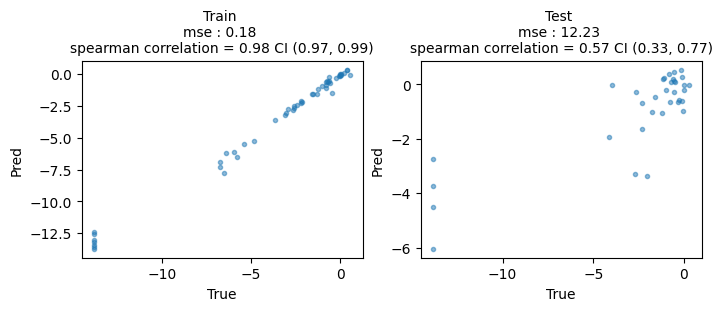

In [36]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [37]:
### Predcting for gen
y_pred = surrogate.predict(embeddings_gen)

In [38]:
y_pred.shape

(8893,)

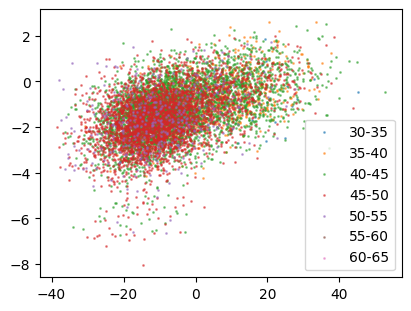

In [39]:
bins = list(range(30, 70, 5))  # Bins from 30 to 100 in steps of 10
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
mut_bin = pd.cut(df_gen['n_mut'], bins=bins, labels=bin_labels, include_lowest=True)
unique_bins = mut_bin.cat.categories

fig, ax = plt.subplots(1,1, figsize=(4,3), layout='constrained')
for _bin in unique_bins:
    _mask = mut_bin == _bin
    im = ax.scatter(df_gen['esmc_masked_marginal'][_mask], y_pred[_mask], alpha=0.5, s=1, label=_bin)
ax.legend()

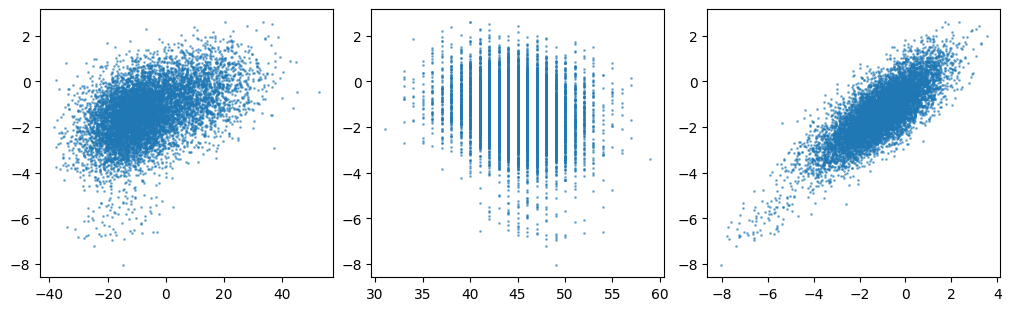

In [41]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].scatter(df_gen['esmc_masked_marginal'], y_pred, alpha=0.5, s=1)
ax[1].scatter(df_gen['n_mut'], y_pred, alpha=0.5, s=1)
ax[2].scatter(df_gen['pred_concat_1'], y_pred, alpha=0.5, s=1)

In [42]:
df_gen['pred_concat_2'] = y_pred

In [43]:
df_gen.head()

,name,sequence,masked_sequence,n_mut,esmc_wt_marginal,esmc_masked_marginal,esmc_pll,esmc_full_wt_marginal,esmc_full_masked_marginal,mut_bin,pred_confit_1,pred_confit_2,pred_confit_3,pred_concat_1,pred_concat_2
0,gxps_ATC_esm3_str_gen_0,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSAADYPKEPYVAPEGEAEQLLAQIWMELLGVERVGRHDNFFALG...,49,-44.019165,-16.101318,-152.53116,-58.318970,-41.270752,40-50,-8.140015,-13.653564,-10.770996,-2.623462,-2.603725
1,gxps_ATC_esm3_str_gen_1,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSDTDYPRTPYIAPEGAVEETLAAIWQDLLQVERVGRHDSFFALG...,47,-41.208496,-12.600098,-149.14124,-52.558716,-31.674561,40-50,-1.620117,-8.660645,-2.838379,-1.587067,-2.153117
2,gxps_ATC_esm3_str_gen_2,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,EPQASDYPAVPYEAPEGEQEQLLAGIWQELLGVERVGRHDNFFALG...,46,-46.686646,-22.641846,-157.42130,-57.561768,-43.364258,40-50,-10.613037,-12.717773,-12.023682,-3.302396,-2.468691
3,gxps_ATC_esm3_str_gen_3,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APAEDSFDRAPYVAPEGEVEQTLAGIWQELLQVERVGRHDSFFELG...,49,-31.578125,-2.216797,-155.64465,-40.660645,-28.473633,40-50,-6.089111,-11.967773,-10.611816,-2.219298,-2.760280
4,gxps_ATC_esm3_str_gen_4,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSEDDYPKPPYVAPEGEVEQLLAKIWQELLGVEKVGRHDSFFALG...,43,-44.613281,-16.470703,-156.66013,-50.236816,-36.729492,40-50,-6.050781,-11.535156,-5.494141,-3.334414,-3.854989


In [44]:
df_gen.to_csv(os.path.join(data_path, 'gen_pred.csv'), index=False)

### Run 3

In [47]:
train_mask, test_mask = df_t_domain['split_id_2'].isin([2]), df_t_domain['split_id_2'].isin([0, 1, 2])
X_train = embeddings_t_domain[train_mask]
X_test = embeddings_t_domain[test_mask]

y_train = df_t_domain.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df_t_domain.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [48]:
print(f'train {train_mask.sum()} test {test_mask.sum()}')

train 85 test 85


In [49]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

train: mse = 0.1371356099843979, spearman correlation = 0.9830388161648147
val: mse = 0.1371356099843979, spearman correlation = 0.9830388161648147


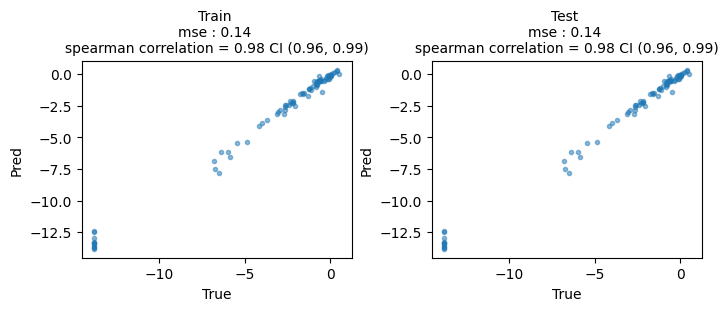

In [50]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(2):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [51]:
### Predcting for gen
y_pred = surrogate.predict(embeddings_gen)

In [52]:
y_pred.shape

(8893,)

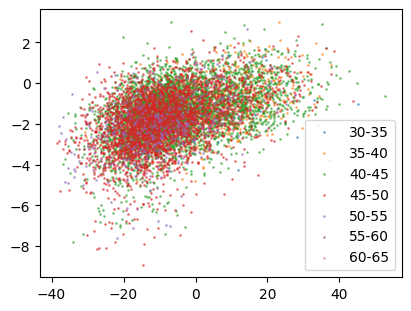

In [53]:
bins = list(range(30, 70, 5))  # Bins from 30 to 100 in steps of 10
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
mut_bin = pd.cut(df_gen['n_mut'], bins=bins, labels=bin_labels, include_lowest=True)
unique_bins = mut_bin.cat.categories

fig, ax = plt.subplots(1,1, figsize=(4,3), layout='constrained')
for _bin in unique_bins:
    _mask = mut_bin == _bin
    im = ax.scatter(df_gen['esmc_masked_marginal'][_mask], y_pred[_mask], alpha=0.5, s=1, label=_bin)
ax.legend()

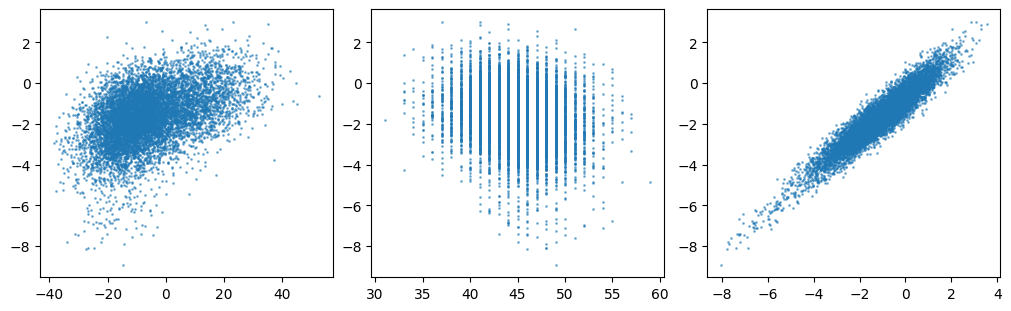

In [54]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].scatter(df_gen['esmc_masked_marginal'], y_pred, alpha=0.5, s=1)
ax[1].scatter(df_gen['n_mut'], y_pred, alpha=0.5, s=1)
ax[2].scatter(df_gen['pred_concat_1'], y_pred, alpha=0.5, s=1)

In [55]:
df_gen['pred_concat_3'] = y_pred

In [56]:
df_gen.head()

,name,sequence,masked_sequence,n_mut,esmc_wt_marginal,esmc_masked_marginal,esmc_pll,esmc_full_wt_marginal,esmc_full_masked_marginal,mut_bin,pred_confit_1,pred_confit_2,pred_confit_3,pred_concat_1,pred_concat_2,pred_concat_3
0,gxps_ATC_esm3_str_gen_0,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSAADYPKEPYVAPEGEAEQLLAQIWMELLGVERVGRHDNFFALG...,49,-44.019165,-16.101318,-152.53116,-58.318970,-41.270752,40-50,-8.140015,-13.653564,-10.770996,-2.623462,-2.603725,-2.519686
1,gxps_ATC_esm3_str_gen_1,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSDTDYPRTPYIAPEGAVEETLAAIWQDLLQVERVGRHDSFFALG...,47,-41.208496,-12.600098,-149.14124,-52.558716,-31.674561,40-50,-1.620117,-8.660645,-2.838379,-1.587067,-2.153117,-2.646813
2,gxps_ATC_esm3_str_gen_2,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,EPQASDYPAVPYEAPEGEQEQLLAGIWQELLGVERVGRHDNFFALG...,46,-46.686646,-22.641846,-157.42130,-57.561768,-43.364258,40-50,-10.613037,-12.717773,-12.023682,-3.302396,-2.468691,-3.325304
3,gxps_ATC_esm3_str_gen_3,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APAEDSFDRAPYVAPEGEVEQTLAGIWQELLQVERVGRHDSFFELG...,49,-31.578125,-2.216797,-155.64465,-40.660645,-28.473633,40-50,-6.089111,-11.967773,-10.611816,-2.219298,-2.760280,-3.676155
4,gxps_ATC_esm3_str_gen_4,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSEDDYPKPPYVAPEGEVEQLLAKIWQELLGVEKVGRHDSFFALG...,43,-44.613281,-16.470703,-156.66013,-50.236816,-36.729492,40-50,-6.050781,-11.535156,-5.494141,-3.334414,-3.854989,-3.998108


In [57]:
df_gen.to_csv(os.path.join(data_path, 'gen_pred.csv'), index=False)